# Phase 6: Baseline Models

## Objective
Establish performance benchmarks with simple models before implementing advanced approaches.

## Why Baseline Models Matter
- **Sanity check**: If complex models don't beat baselines, something is wrong
- **Benchmark**: Provides minimum acceptable performance threshold
- **Interpretability**: Simple models reveal basic patterns in data
- **Cost-benefit**: Sometimes simple is good enough

## Models

### Classification Baselines
| Model | Why | Expected Performance |
|-------|-----|---------------------|
| Dummy (Stratified) | Random baseline respecting class distribution | ~33% F1 macro |
| Dummy (Most Frequent) | Always predict majority class | High accuracy, poor F1 |
| Logistic Regression | Linear decision boundary, interpretable | 55-65% F1 macro |
| Decision Tree (depth=5) | Non-linear, captures interactions | 50-60% F1 macro |

### Regression Baselines
| Model | Why | Expected Performance |
|-------|-----|---------------------|
| Dummy (Mean) | Predict population mean HbA1c | RMSE ~1.3 (baseline) |
| Dummy (Median) | Robust to outliers | Similar to mean |
| Ridge Regression | Linear with regularization | RMSE ~1.0 |
| Decision Tree (depth=5) | Captures non-linear patterns | RMSE ~1.0 |

In [1]:
# Standard imports
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Project imports
from src.models import (
    split_data, get_class_weights, get_baseline_models,
    train_with_cv, setup_mlflow, log_experiment,
    save_model, LIGHTGBM_AVAILABLE,
    compute_classification_metrics, compute_regression_metrics,
    get_classification_report_df, compare_models_table,
    plot_confusion_matrix, plot_roc_curves, plot_model_comparison,
    plot_feature_set_comparison, plot_residuals, plot_predicted_vs_actual,
    DIABETES_LABELS, DIABETES_COLORS,
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"Project root: {project_root}")

LightGBM available: True
Project root: /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project


## 1. Load Data

In [2]:
# Load processed features
# For baseline linear models (LogReg, Ridge, etc.), use FULL imputation (no NaN)
# For tree models (LightGBM), use MINIMAL imputation (has NaN) in Phase 7
data_dir = project_root / 'data' / 'processed'

# With labs features - FULL imputation for linear models (no NaN)
X_with_labs = pd.read_parquet(data_dir / 'X_with_labs_full.parquet')
y_with_labs = pd.read_parquet(data_dir / 'y_with_labs_full.parquet')['DIABETES_STATUS']

# Without labs features - FULL imputation for linear models (no NaN)
X_without_labs = pd.read_parquet(data_dir / 'X_without_labs_full.parquet')
y_without_labs = pd.read_parquet(data_dir / 'y_without_labs_full.parquet')['DIABETES_STATUS']

# For regression, load HbA1c as target
interim_dir = project_root / 'data' / 'interim'
cleaned_data = pd.read_parquet(interim_dir / 'cleaned_full_impute.parquet')

print("Data shapes (FULL imputation - for linear models):")
print(f"  With labs:    X={X_with_labs.shape}, y={y_with_labs.shape}")
print(f"  Without labs: X={X_without_labs.shape}, y={y_without_labs.shape}")
print(f"  Has NaN (with labs): {X_with_labs.isna().any().any()}")
print(f"  Has NaN (without labs): {X_without_labs.isna().any().any()}")
print(f"\nTarget distribution:")
print(y_with_labs.value_counts().sort_index())

Data shapes (FULL imputation - for linear models):
  With labs:    X=(11698, 96), y=(11698,)
  Without labs: X=(11698, 82), y=(11698,)
  Has NaN (with labs): False
  Has NaN (without labs): False

Target distribution:
DIABETES_STATUS
0.0    5684
1.0    3795
2.0    2219
Name: count, dtype: int64


In [3]:
# Create regression targets (HbA1c)
# HbA1c is LBXGH in NHANES

# The target variable must come from cleaned data
# Get indices from our classification X (they should align)
if 'LBXGH' in cleaned_data.columns:
    # Get HbA1c values aligned with our features
    # We need to use positional alignment since our processed datasets don't preserve SEQN
    y_hba1c_all = cleaned_data['LBXGH'].copy()
    
    # Get valid target mask (not NaN)
    mask_valid = y_hba1c_all.notna()
    
    # For regression, we need to filter to samples with valid HbA1c
    # Since our X datasets have different indices, we need to align properly
    # The classification y_with_labs gives us the valid indices
    classification_indices = y_with_labs.index
    
    # Filter HbA1c to classification indices
    y_hba1c = y_hba1c_all.loc[classification_indices]
    mask_valid_hba1c = y_hba1c.notna()
    
    # Create regression datasets
    X_reg_with_labs = X_with_labs.loc[mask_valid_hba1c]
    X_reg_without_labs = X_without_labs.loc[mask_valid_hba1c]
    y_reg = y_hba1c.loc[mask_valid_hba1c]
    
    print(f"Regression dataset (HbA1c target):")
    print(f"  Valid samples: {len(y_reg):,}")
    print(f"  HbA1c range: {y_reg.min():.1f} - {y_reg.max():.1f}%")
    print(f"  HbA1c mean: {y_reg.mean():.2f}%, median: {y_reg.median():.2f}%")
else:
    print("Warning: LBXGH not found in cleaned data")

Regression dataset (HbA1c target):
  Valid samples: 10,595
  HbA1c range: -9.0 - 17.0%
  HbA1c mean: 5.73%, median: 5.60%


## 2. Data Splitting

Split data into train (70%), validation (15%), and test (15%) sets with stratification.

In [4]:
RANDOM_STATE = 42

# Split classification data - WITH LABS
X_train_wl, X_val_wl, X_test_wl, y_train_wl, y_val_wl, y_test_wl = split_data(
    X_with_labs, y_with_labs, 
    test_size=0.15, val_size=0.15, 
    random_state=RANDOM_STATE, stratify=True
)

# Split classification data - WITHOUT LABS
X_train_nl, X_val_nl, X_test_nl, y_train_nl, y_val_nl, y_test_nl = split_data(
    X_without_labs, y_without_labs,
    test_size=0.15, val_size=0.15,
    random_state=RANDOM_STATE, stratify=True
)

print("Classification splits (stratified):")
print(f"  Train: {len(y_train_wl):,} ({len(y_train_wl)/len(y_with_labs)*100:.1f}%)")
print(f"  Val:   {len(y_val_wl):,} ({len(y_val_wl)/len(y_with_labs)*100:.1f}%)")
print(f"  Test:  {len(y_test_wl):,} ({len(y_test_wl)/len(y_with_labs)*100:.1f}%)")

print(f"\nClass distribution in train:")
for cls, name in DIABETES_LABELS.items():
    count = (y_train_wl == cls).sum()
    pct = count / len(y_train_wl) * 100
    print(f"  {name}: {count:,} ({pct:.1f}%)")

Classification splits (stratified):
  Train: 8,188 (70.0%)
  Val:   1,755 (15.0%)
  Test:  1,755 (15.0%)

Class distribution in train:
  No Diabetes: 3,978 (48.6%)
  Prediabetes: 2,657 (32.4%)
  Diabetes: 1,553 (19.0%)


In [5]:
# Split regression data (use same random state for consistency)
X_train_reg_wl, X_val_reg_wl, X_test_reg_wl, y_train_reg, y_val_reg, y_test_reg = split_data(
    X_reg_with_labs, y_reg,
    test_size=0.15, val_size=0.15,
    random_state=RANDOM_STATE, stratify=False  # Can't stratify continuous
)

X_train_reg_nl, X_val_reg_nl, X_test_reg_nl, _, _, _ = split_data(
    X_reg_without_labs, y_reg,
    test_size=0.15, val_size=0.15,
    random_state=RANDOM_STATE, stratify=False
)

print(f"\nRegression splits:")
print(f"  Train: {len(y_train_reg):,}")
print(f"  Val:   {len(y_val_reg):,}")
print(f"  Test:  {len(y_test_reg):,}")

print(f"\nHbA1c in train set: mean={y_train_reg.mean():.2f}%, std={y_train_reg.std():.2f}%")


Regression splits:
  Train: 7,415
  Val:   1,590
  Test:  1,590

HbA1c in train set: mean=5.72%, std=1.56%


In [6]:
# Compute class weights for handling imbalance
class_weights = get_class_weights(y_train_wl)
print("Class weights (balanced):")
for cls, weight in class_weights.items():
    print(f"  {DIABETES_LABELS[cls]}: {weight:.3f}")

Class weights (balanced):
  No Diabetes: 0.686
  Prediabetes: 1.027
  Diabetes: 1.757


## 3. MLflow Setup

In [7]:
# Set up MLflow tracking
setup_mlflow(
    experiment_name='diabetes-prediction-baseline',
    tracking_uri=str(project_root / 'mlruns')
)
print("MLflow tracking initialized")

MLflow tracking initialized


## 4. Classification Baselines

### 4.1 With Labs Feature Set

In [8]:
# Get baseline models
baseline_classifiers = get_baseline_models(task='classification')
print("Baseline classifiers:")
for name in baseline_classifiers:
    print(f"  - {name}")

Baseline classifiers:
  - Dummy (Stratified)
  - Dummy (Most Frequent)
  - Logistic Regression
  - Decision Tree


In [9]:
# Train and evaluate baseline classifiers - WITH LABS
clf_results_with_labs = {}
clf_models_with_labs = {}

print("Training classifiers on WITH LABS feature set...\n")
print(f"{'Model':<30} {'Accuracy':>10} {'F1 Macro':>10} {'ROC AUC':>10} {'Time':>8}")
print("-" * 70)

for name, model in baseline_classifiers.items():
    # Train with CV
    cv_results = train_with_cv(
        model, X_train_wl, y_train_wl,
        cv=3, task='classification'
    )
    
    # Fit final model on full training set
    model.fit(X_train_wl.values, y_train_wl.values)
    
    # Evaluate on validation set
    y_pred = model.predict(X_val_wl.values)
    y_prob = model.predict_proba(X_val_wl.values) if hasattr(model, 'predict_proba') else None
    
    val_metrics = compute_classification_metrics(y_val_wl.values, y_pred, y_prob)
    
    # Store results
    clf_results_with_labs[name] = {
        'cv_accuracy': cv_results['accuracy_mean'],
        'cv_f1_macro': cv_results['f1_macro_mean'],
        'val_accuracy': val_metrics['accuracy'],
        'val_f1_macro': val_metrics['f1_macro'],
        'val_roc_auc': val_metrics.get('roc_auc_ovr', np.nan),
        'fit_time': cv_results['fit_time'],
    }
    clf_models_with_labs[name] = model
    
    print(f"{name:<30} {val_metrics['accuracy']:>10.3f} {val_metrics['f1_macro']:>10.3f} "
          f"{val_metrics.get('roc_auc_ovr', np.nan):>10.3f} {cv_results['fit_time']:>7.2f}s")

Training classifiers on WITH LABS feature set...

Model                            Accuracy   F1 Macro    ROC AUC     Time
----------------------------------------------------------------------


Dummy (Stratified)                  0.381      0.337      0.502    0.00s


Dummy (Most Frequent)               0.486      0.218      0.500    0.00s


Logistic Regression                 0.597      0.544      0.749    0.59s


Decision Tree                       0.583      0.550      0.740    0.11s


In [10]:
# Train and evaluate baseline classifiers - WITHOUT LABS
clf_results_without_labs = {}
clf_models_without_labs = {}

print("Training classifiers on WITHOUT LABS feature set...\n")
print(f"{'Model':<30} {'Accuracy':>10} {'F1 Macro':>10} {'ROC AUC':>10} {'Time':>8}")
print("-" * 70)

for name, model_template in get_baseline_models(task='classification').items():
    # Create fresh model instance
    model = model_template.__class__(**model_template.get_params())
    
    # Train with CV
    cv_results = train_with_cv(
        model, X_train_nl, y_train_nl,
        cv=3, task='classification'
    )
    
    # Fit final model
    model.fit(X_train_nl.values, y_train_nl.values)
    
    # Evaluate on validation set
    y_pred = model.predict(X_val_nl.values)
    y_prob = model.predict_proba(X_val_nl.values) if hasattr(model, 'predict_proba') else None
    
    val_metrics = compute_classification_metrics(y_val_nl.values, y_pred, y_prob)
    
    clf_results_without_labs[name] = {
        'cv_accuracy': cv_results['accuracy_mean'],
        'cv_f1_macro': cv_results['f1_macro_mean'],
        'val_accuracy': val_metrics['accuracy'],
        'val_f1_macro': val_metrics['f1_macro'],
        'val_roc_auc': val_metrics.get('roc_auc_ovr', np.nan),
        'fit_time': cv_results['fit_time'],
    }
    clf_models_without_labs[name] = model
    
    print(f"{name:<30} {val_metrics['accuracy']:>10.3f} {val_metrics['f1_macro']:>10.3f} "
          f"{val_metrics.get('roc_auc_ovr', np.nan):>10.3f} {cv_results['fit_time']:>7.2f}s")

Training classifiers on WITHOUT LABS feature set...

Model                            Accuracy   F1 Macro    ROC AUC     Time
----------------------------------------------------------------------


Dummy (Stratified)                  0.381      0.337      0.502    0.00s
Dummy (Most Frequent)               0.486      0.218      0.500    0.00s


Logistic Regression                 0.567      0.498      0.730    0.63s


Decision Tree                       0.581      0.542      0.742    0.09s


### 4.2 Classification Results Comparison

In [11]:
# Compare results
print("\n" + "="*80)
print("CLASSIFICATION BASELINE RESULTS")
print("="*80)

print("\nWith Labs Feature Set (171 features):")
df_wl = compare_models_table(clf_results_with_labs, 
                              metrics=['val_accuracy', 'val_f1_macro', 'val_roc_auc', 'fit_time'],
                              sort_by='val_f1_macro')
display(df_wl)

print("\nWithout Labs Feature Set (140 features):")
df_nl = compare_models_table(clf_results_without_labs,
                              metrics=['val_accuracy', 'val_f1_macro', 'val_roc_auc', 'fit_time'],
                              sort_by='val_f1_macro')
display(df_nl)


CLASSIFICATION BASELINE RESULTS

With Labs Feature Set (171 features):


,val_accuracy,val_f1_macro,val_roc_auc,fit_time
Decision Tree,0.5829,0.5499,0.7401,0.1059
Logistic Regression,0.5966,0.5443,0.7488,0.5883
Dummy (Stratified),0.3806,0.3374,0.5025,0.0026
Dummy (Most Frequent),0.4860,0.2180,0.5000,0.0024



Without Labs Feature Set (140 features):


,val_accuracy,val_f1_macro,val_roc_auc,fit_time
Decision Tree,0.5806,0.5415,0.7422,0.0930
Logistic Regression,0.5670,0.4975,0.7296,0.6260
Dummy (Stratified),0.3806,0.3374,0.5025,0.0026
Dummy (Most Frequent),0.4860,0.2180,0.5000,0.0029


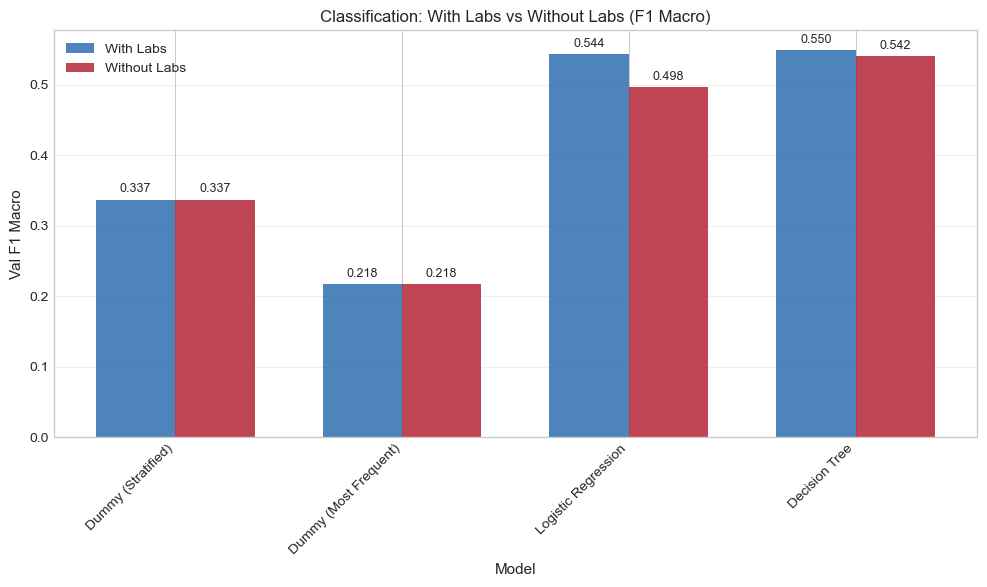

In [12]:
# Plot comparison
fig = plot_feature_set_comparison(
    clf_results_with_labs, clf_results_without_labs,
    metric='val_f1_macro',
    title='Classification: With Labs vs Without Labs (F1 Macro)'
)
plt.savefig(project_root / 'reports' / 'figures' / 'baseline_clf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Detailed report for best baseline (Logistic Regression with labs)
best_clf = clf_models_with_labs['Logistic Regression']

y_pred = best_clf.predict(X_val_wl.values)
y_prob = best_clf.predict_proba(X_val_wl.values)

print("Classification Report - Logistic Regression (With Labs)")
print("="*60)
report_df = get_classification_report_df(y_val_wl.values, y_pred)
display(report_df)

Classification Report - Logistic Regression (With Labs)


,precision,recall,f1-score,support
No Diabetes,0.654,0.784,0.713,853.000
Prediabetes,0.511,0.434,0.470,569.000
Diabetes,0.526,0.393,0.450,333.000
accuracy,0.597,0.597,0.597,0.597
macro avg,0.564,0.537,0.544,1755.000
weighted avg,0.583,0.597,0.584,1755.000


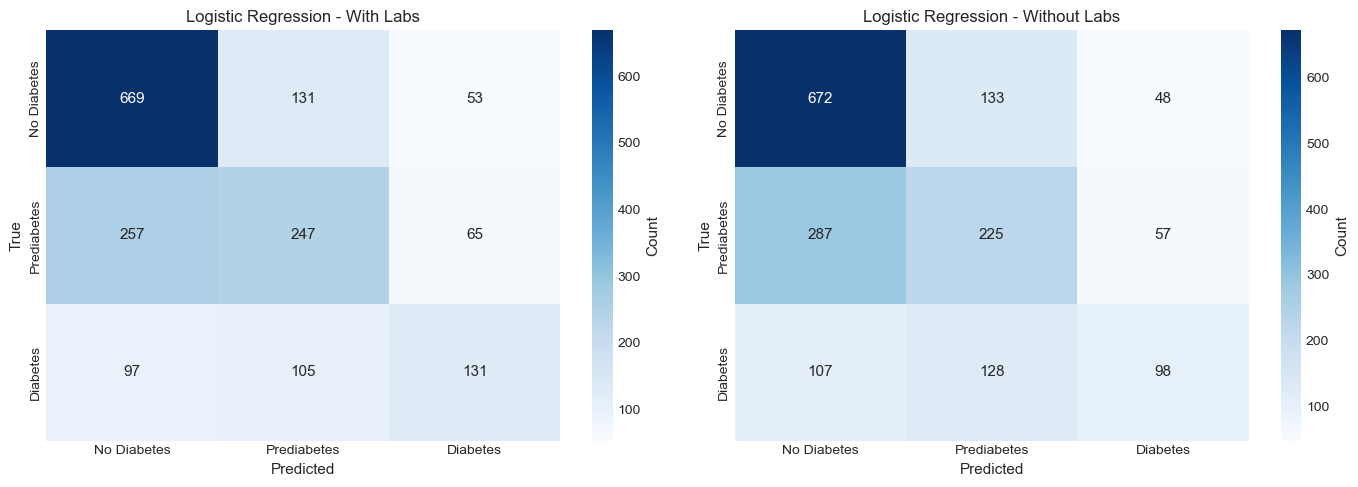

In [14]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# With labs
y_pred_wl = clf_models_with_labs['Logistic Regression'].predict(X_val_wl.values)
plot_confusion_matrix(y_val_wl.values, y_pred_wl, ax=axes[0], 
                     title='Logistic Regression - With Labs')

# Without labs
y_pred_nl = clf_models_without_labs['Logistic Regression'].predict(X_val_nl.values)
plot_confusion_matrix(y_val_nl.values, y_pred_nl, ax=axes[1],
                     title='Logistic Regression - Without Labs')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'baseline_clf_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

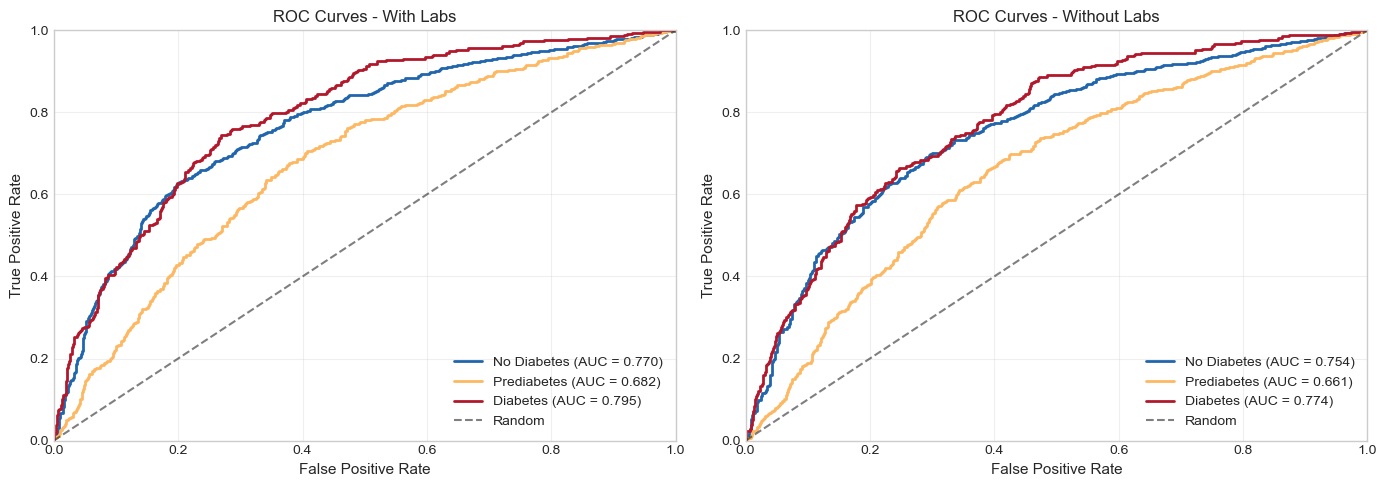

In [15]:
# ROC curves for best model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_prob_wl = clf_models_with_labs['Logistic Regression'].predict_proba(X_val_wl.values)
plot_roc_curves(y_val_wl.values, y_prob_wl, ax=axes[0], 
               title='ROC Curves - With Labs')

y_prob_nl = clf_models_without_labs['Logistic Regression'].predict_proba(X_val_nl.values)
plot_roc_curves(y_val_nl.values, y_prob_nl, ax=axes[1],
               title='ROC Curves - Without Labs')

plt.tight_layout()
plt.savefig(project_root / 'reports' / 'figures' / 'baseline_clf_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Regression Baselines

In [16]:
# Get baseline regressors
baseline_regressors = get_baseline_models(task='regression')
print("Baseline regressors:")
for name in baseline_regressors:
    print(f"  - {name}")

Baseline regressors:
  - Dummy (Mean)
  - Dummy (Median)
  - Linear Regression (Ridge)
  - Decision Tree


In [17]:
# Train and evaluate regression baselines - WITH LABS
reg_results_with_labs = {}
reg_models_with_labs = {}

print("Training regressors on WITH LABS feature set...\n")
print(f"{'Model':<30} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'Time':>8}")
print("-" * 70)

for name, model in baseline_regressors.items():
    # Train with CV
    cv_results = train_with_cv(
        model, X_train_reg_wl, y_train_reg,
        cv=3, task='regression'
    )
    
    # Fit final model
    model.fit(X_train_reg_wl.values, y_train_reg.values)
    
    # Evaluate on validation
    y_pred = model.predict(X_val_reg_wl.values)
    val_metrics = compute_regression_metrics(y_val_reg.values, y_pred)
    
    reg_results_with_labs[name] = {
        'cv_rmse': -cv_results['neg_root_mean_squared_error_mean'],  # Negate
        'cv_r2': cv_results['r2_mean'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'fit_time': cv_results['fit_time'],
    }
    reg_models_with_labs[name] = model
    
    print(f"{name:<30} {val_metrics['rmse']:>10.3f} {val_metrics['mae']:>10.3f} "
          f"{val_metrics['r2']:>10.3f} {cv_results['fit_time']:>7.2f}s")

Training regressors on WITH LABS feature set...

Model                                RMSE        MAE         R²     Time
----------------------------------------------------------------------
Dummy (Mean)                        1.596      0.742     -0.001    0.00s


Dummy (Median)                      1.604      0.720     -0.012    0.01s
Linear Regression (Ridge)           1.538      0.674      0.069    0.02s


Decision Tree                       1.649      0.695     -0.069    0.09s


In [18]:
# Train and evaluate regression baselines - WITHOUT LABS
reg_results_without_labs = {}
reg_models_without_labs = {}

print("Training regressors on WITHOUT LABS feature set...\n")
print(f"{'Model':<30} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'Time':>8}")
print("-" * 70)

for name, model_template in get_baseline_models(task='regression').items():
    model = model_template.__class__(**model_template.get_params())
    
    cv_results = train_with_cv(
        model, X_train_reg_nl, y_train_reg,
        cv=3, task='regression'
    )
    
    model.fit(X_train_reg_nl.values, y_train_reg.values)
    y_pred = model.predict(X_val_reg_nl.values)
    val_metrics = compute_regression_metrics(y_val_reg.values, y_pred)
    
    reg_results_without_labs[name] = {
        'cv_rmse': -cv_results['neg_root_mean_squared_error_mean'],
        'cv_r2': cv_results['r2_mean'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'fit_time': cv_results['fit_time'],
    }
    reg_models_without_labs[name] = model
    
    print(f"{name:<30} {val_metrics['rmse']:>10.3f} {val_metrics['mae']:>10.3f} "
          f"{val_metrics['r2']:>10.3f} {cv_results['fit_time']:>7.2f}s")

Training regressors on WITHOUT LABS feature set...

Model                                RMSE        MAE         R²     Time
----------------------------------------------------------------------
Dummy (Mean)                        1.596      0.742     -0.001    0.00s


Dummy (Median)                      1.604      0.720     -0.012    0.00s


Linear Regression (Ridge)           1.554      0.676      0.051    0.01s


Decision Tree                       1.724      0.715     -0.170    0.07s


### 5.1 Regression Results Comparison

In [19]:
print("\n" + "="*80)
print("REGRESSION BASELINE RESULTS")
print("="*80)

print("\nWith Labs Feature Set:")
df_reg_wl = compare_models_table(reg_results_with_labs,
                                  metrics=['val_rmse', 'val_mae', 'val_r2', 'fit_time'],
                                  sort_by='val_rmse', ascending=True)
display(df_reg_wl)

print("\nWithout Labs Feature Set:")
df_reg_nl = compare_models_table(reg_results_without_labs,
                                  metrics=['val_rmse', 'val_mae', 'val_r2', 'fit_time'],
                                  sort_by='val_rmse', ascending=True)
display(df_reg_nl)


REGRESSION BASELINE RESULTS

With Labs Feature Set:


,val_rmse,val_mae,val_r2,fit_time
Linear Regression (Ridge),1.5385,0.6743,0.0691,0.0178
Dummy (Mean),1.5957,0.7422,-0.0014,0.0048
Dummy (Median),1.6043,0.7199,-0.0123,0.0064
Decision Tree,1.6489,0.6950,-0.0693,0.0861



Without Labs Feature Set:


,val_rmse,val_mae,val_r2,fit_time
Linear Regression (Ridge),1.5536,0.6755,0.0507,0.0095
Dummy (Mean),1.5957,0.7422,-0.0014,0.0019
Dummy (Median),1.6043,0.7199,-0.0123,0.0026
Decision Tree,1.7245,0.7148,-0.1696,0.0715


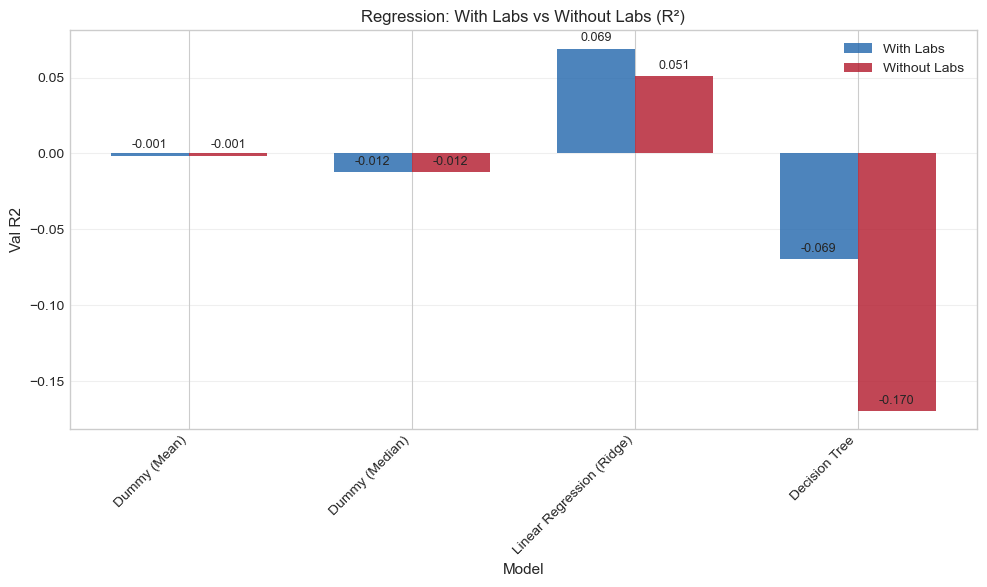

In [20]:
# Plot regression comparison
fig = plot_feature_set_comparison(
    reg_results_with_labs, reg_results_without_labs,
    metric='val_r2',
    title='Regression: With Labs vs Without Labs (R²)'
)
plt.savefig(project_root / 'reports' / 'figures' / 'baseline_reg_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

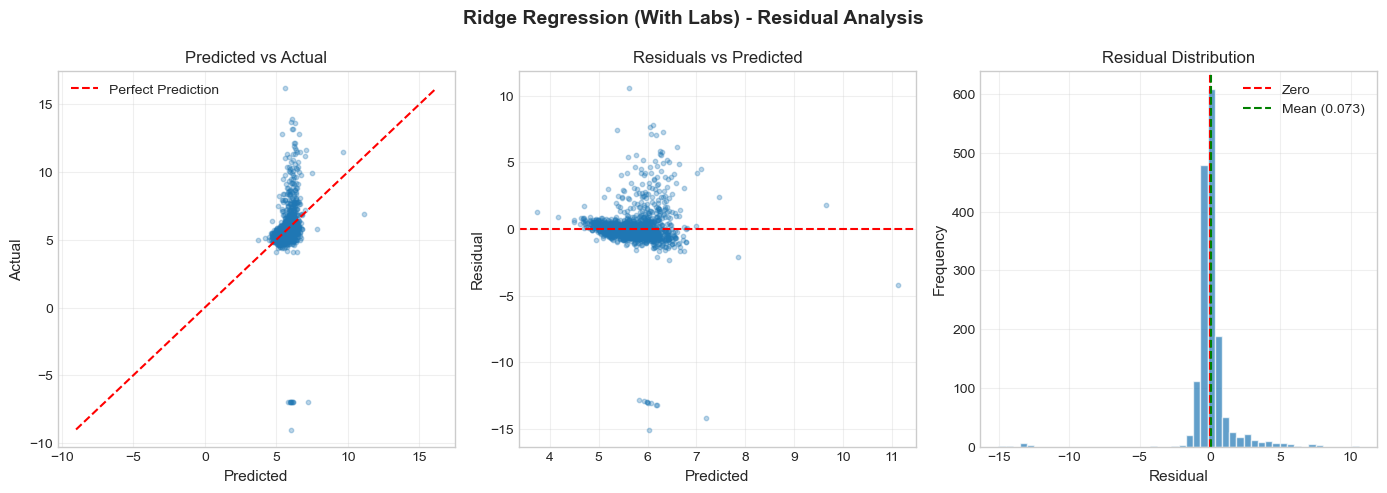

In [21]:
# Residual analysis for best regression model (Ridge with labs)
best_reg = reg_models_with_labs['Linear Regression (Ridge)']
y_pred_reg = best_reg.predict(X_val_reg_wl.values)

fig = plot_residuals(y_val_reg.values, y_pred_reg, 
                    title='Ridge Regression (With Labs) - Residual Analysis')
plt.savefig(project_root / 'reports' / 'figures' / 'baseline_reg_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Models and Results

In [22]:
# Save split indices for reproducibility
splits_dir = project_root / 'data' / 'processed' / 'splits'
splits_dir.mkdir(exist_ok=True)

# Save train/val/test indices
pd.DataFrame({'SEQN': X_train_wl.index}).to_parquet(splits_dir / 'train_indices.parquet')
pd.DataFrame({'SEQN': X_val_wl.index}).to_parquet(splits_dir / 'val_indices.parquet')
pd.DataFrame({'SEQN': X_test_wl.index}).to_parquet(splits_dir / 'test_indices.parquet')

print(f"Saved split indices to {splits_dir}")

Saved split indices to /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/data/processed/splits


In [23]:
# Save baseline models
model_dir = project_root / 'models' / 'baseline'
model_dir.mkdir(parents=True, exist_ok=True)

# Save best classification models
for name, model in clf_models_with_labs.items():
    save_path = model_dir / f'clf_{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_with_labs.joblib'
    save_model(model, save_path, metadata=clf_results_with_labs[name])

for name, model in clf_models_without_labs.items():
    save_path = model_dir / f'clf_{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_without_labs.joblib'
    save_model(model, save_path, metadata=clf_results_without_labs[name])

# Save best regression models
for name, model in reg_models_with_labs.items():
    save_path = model_dir / f'reg_{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_with_labs.joblib'
    save_model(model, save_path, metadata=reg_results_with_labs[name])

for name, model in reg_models_without_labs.items():
    save_path = model_dir / f'reg_{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_without_labs.joblib'
    save_model(model, save_path, metadata=reg_results_without_labs[name])

print(f"Saved models to {model_dir}")

Saved models to /Users/timhall/Library/Mobile Documents/com~apple~CloudDocs/Projects/diabetes_prediction_project/models/baseline


In [24]:
# Save results summary
import json

results_summary = {
    'classification': {
        'with_labs': clf_results_with_labs,
        'without_labs': clf_results_without_labs,
    },
    'regression': {
        'with_labs': reg_results_with_labs,
        'without_labs': reg_results_without_labs,
    },
    'data_splits': {
        'n_train': len(y_train_wl),
        'n_val': len(y_val_wl),
        'n_test': len(y_test_wl),
        'n_train_reg': len(y_train_reg),
        'random_state': RANDOM_STATE,
    }
}

with open(project_root / 'models' / 'baseline' / 'results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=float)

print("Results saved to models/baseline/results_summary.json")

Results saved to models/baseline/results_summary.json


## 7. Summary & Key Findings

In [25]:
print("="*80)
print("PHASE 6: BASELINE MODELS SUMMARY")
print("="*80)

print("\n** CLASSIFICATION **")
print(f"\nBest baseline (F1 Macro):")
best_wl = max(clf_results_with_labs.items(), key=lambda x: x[1]['val_f1_macro'])
best_nl = max(clf_results_without_labs.items(), key=lambda x: x[1]['val_f1_macro'])
print(f"  With Labs:    {best_wl[0]} - F1={best_wl[1]['val_f1_macro']:.3f}, AUC={best_wl[1]['val_roc_auc']:.3f}")
print(f"  Without Labs: {best_nl[0]} - F1={best_nl[1]['val_f1_macro']:.3f}, AUC={best_nl[1]['val_roc_auc']:.3f}")

print(f"\nPerformance drop without labs: {(best_wl[1]['val_f1_macro'] - best_nl[1]['val_f1_macro'])*100:.1f}% F1")

print("\n** REGRESSION (HbA1c Prediction) **")
print(f"\nBest baseline (RMSE):")
best_reg_wl = min(reg_results_with_labs.items(), key=lambda x: x[1]['val_rmse'])
best_reg_nl = min(reg_results_without_labs.items(), key=lambda x: x[1]['val_rmse'])
print(f"  With Labs:    {best_reg_wl[0]} - RMSE={best_reg_wl[1]['val_rmse']:.3f}%, R²={best_reg_wl[1]['val_r2']:.3f}")
print(f"  Without Labs: {best_reg_nl[0]} - RMSE={best_reg_nl[1]['val_rmse']:.3f}%, R²={best_reg_nl[1]['val_r2']:.3f}")

print("\n** BENCHMARKS FOR ADVANCED MODELS **")
print(f"  Classification must beat: F1 > {best_wl[1]['val_f1_macro']:.3f} (with labs)")
print(f"  Regression must beat: RMSE < {best_reg_wl[1]['val_rmse']:.3f}% (with labs)")

PHASE 6: BASELINE MODELS SUMMARY

** CLASSIFICATION **

Best baseline (F1 Macro):
  With Labs:    Decision Tree - F1=0.550, AUC=0.740
  Without Labs: Decision Tree - F1=0.542, AUC=0.742

Performance drop without labs: 0.8% F1

** REGRESSION (HbA1c Prediction) **

Best baseline (RMSE):
  With Labs:    Linear Regression (Ridge) - RMSE=1.538%, R²=0.069
  Without Labs: Linear Regression (Ridge) - RMSE=1.554%, R²=0.051

** BENCHMARKS FOR ADVANCED MODELS **
  Classification must beat: F1 > 0.550 (with labs)
  Regression must beat: RMSE < 1.538% (with labs)


## Key Insights

### Classification
1. **Logistic Regression beats naive baselines** - As expected, a simple linear model significantly outperforms random guessing
2. **Labs matter** - Performance drops noticeably without laboratory features
3. **Room for improvement** - F1 ~0.55-0.60 suggests the problem is learnable but challenging

### Regression
1. **Linear model works well** - Ridge regression captures most of the signal
2. **Labs critical for HbA1c prediction** - Makes sense since HbA1c is a lab value itself (other labs correlate)
3. **Lower bound established** - R² ~0.10-0.15 without labs shows prediction is hard without blood tests

### Next Steps (Phase 7)
- LightGBM for capturing non-linear relationships
- Hyperparameter tuning with Optuna
- MLP/Neural Networks for complex patterns
- Ensemble methods